<a href="https://colab.research.google.com/github/Art-MC/SIPRAD_demo/blob/main/test_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Art-MC/SIPRAD-demo/blob/main/test_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%load_ext autoreload
%autoreload 2

In [1]:
!git clone https://github.com/Art-MC/SIPRAD_demo.git
!git clone https://github.com/PyLorentz/PyLorentz.git
!pip install ncempy

fatal: destination path 'SIPRAD_demo' already exists and is not an empty directory.
fatal: destination path 'PyLorentz' already exists and is not an empty directory.


In [2]:
import torch
from pathlib import Path
import numpy as np

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))
device = torch.device(f'cuda:{0}')

import scipy.ndimage as ndi
import skimage.io as skio


from PyLorentz.PyTIE import SITIE

GPU: Tesla T4


Helper functions, move to helper file and import
- imshow
- vector show

loading true data

In [3]:
true_phase = skio.imread("SIPRAD_demo/example_data/true_phase.tif")
true_amp = np.ones_like(true_phase)
scale = 4 # nm/pix

pdict = {}
pdict['del_px'] = scale
pdict['save_home'] = "./"
pdict['dataname'] = "SIPRAD_demo_CGT"
pdict['device'] = device
pdict['mode'] = "sim"

In [4]:
from SIPRAD_demo.utils.show import show_im, show_2D


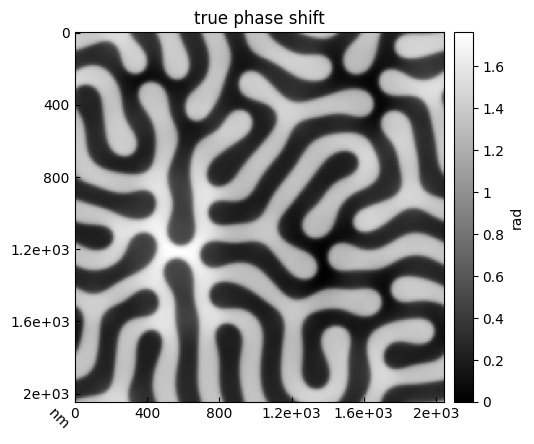

In [5]:
show_im(true_phase, scale=scale,  title="true phase shift", cbar_title='rad')

In [6]:
from SIPRAD_demo.utils.utils import induction_from_phase
true_By, true_Bx = induction_from_phase(true_phase, scale)

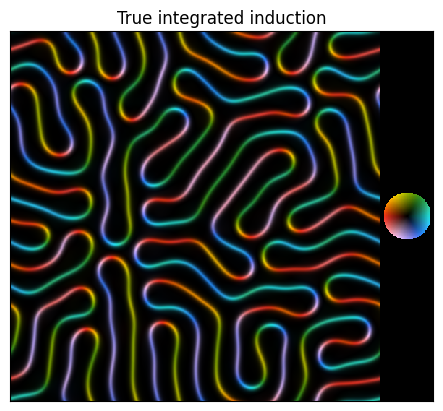

In [7]:
show_2D(true_Bx, true_By, a=0, cmap='hsv', title="True integrated induction")

## Simulate input images and optionally add noise

In [8]:
from SIPRAD_demo.utils.noise import image_noiser
from SIPRAD_demo.utils.utils import get_TF
from SIPRAD_demo.utils.microscopes import Microscope
from SIPRAD_demo.AD.AD_funcs import sim_images_torch

defvals (mm): [-1.]


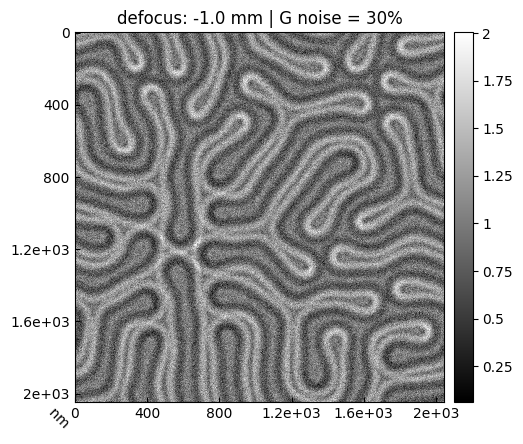

In [9]:
dfs = [-1_000_000] # -1mm
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
GNoise = 30 # % Gaussian noise

# dfs = np.array(sorted(dfs) + [0] + [-1*i for i in reversed(sorted(dfs))])
# dfs = [dfs[0], -1*dfs[0]]

noiser = image_noiser(
    gauss = GNoise, # percent noise, 0+
    poisson = 0., # 0+ , ~0.4
    salt_and_pepper = 0, # 0+, ~10
    blur = 0, # sigma, 0+, ~0.5
    contrast = None, # 1-, 1+
    bkg = 0, # 0+, ~1
    seed = 42,
)

pdict["defvals"] = np.array(dfs)
pdict['noise_vals'] = noiser.__dict__
print(f"defvals (mm): {pdict['defvals']/1e6}")

TFs = torch.tensor(np.array([get_TF(pscope, true_phase.shape, defval, pdict["del_px"]) for defval in pdict["defvals"]]),
                         device=device)

inp_ims_nonoise = sim_images_torch(torch.tensor(true_phase, device=device),
                     TFs,
                     torch.tensor(true_amp, device=device),
                     )

inp_ims = noiser.run(inp_ims_nonoise).float()
show_im(inp_ims[0].cpu().detach().numpy(), scale=pdict['del_px'], title=f"defocus: {pdict['defvals'][0]/1e6} mm | G noise = {noiser.gauss}%")

# SIPRAD

In [10]:
from SIPRAD_demo.NNs.DIP_NN import DIP_NN
from SIPRAD_demo.AD.AD_funcs import training_loop
import matplotlib.pyplot as plt
from SIPRAD_demo.utils.utils import get_all_accs


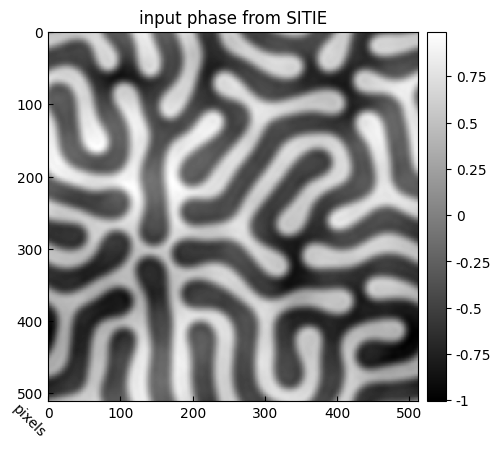

Beginning run for 240204-0625_SIPRAD_demo_CGT_df-1.0mm_PN30_AD
Defocus values (mm): [-1.]

1/1000, 0.11 s : loss 3.270e-02, lr 2.00e-01


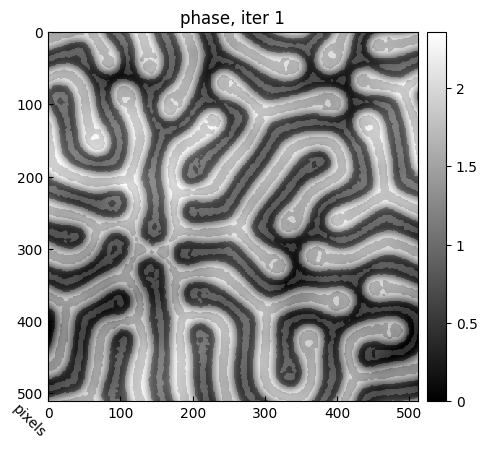

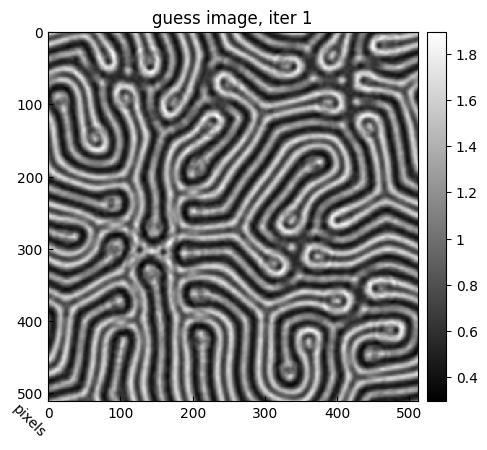

Epoch 00142: reducing learning rate of group 0 to 1.5000e-01.
Epoch 00193: reducing learning rate of group 0 to 1.1250e-01.
200/1000, 1.62 s : loss 1.969e-02, lr 1.13e-01


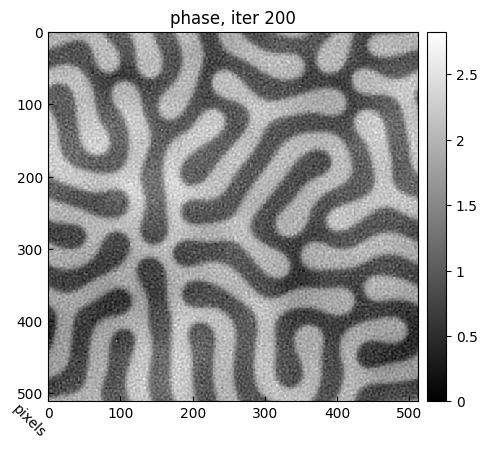

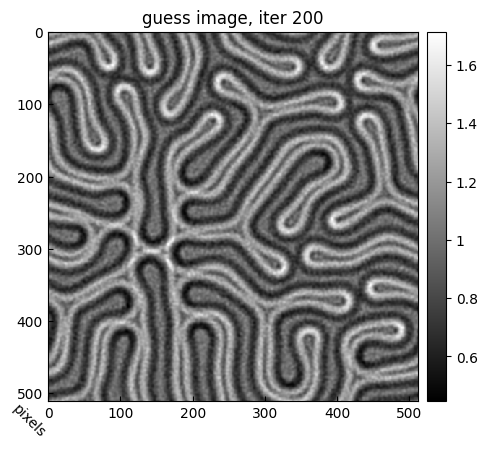

Epoch 00262: reducing learning rate of group 0 to 8.4375e-02.
Epoch 00313: reducing learning rate of group 0 to 6.3281e-02.
Epoch 00364: reducing learning rate of group 0 to 4.7461e-02.
400/1000, 2.11 s : loss 1.969e-02, lr 4.75e-02


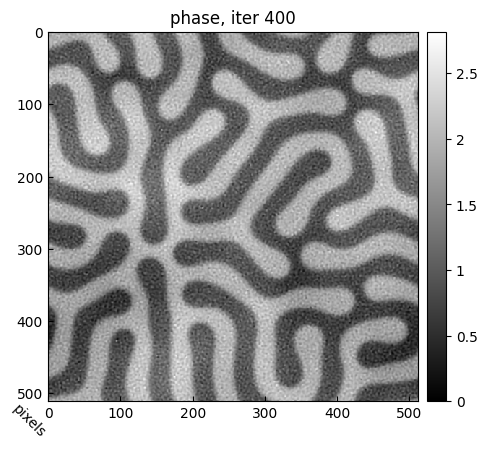

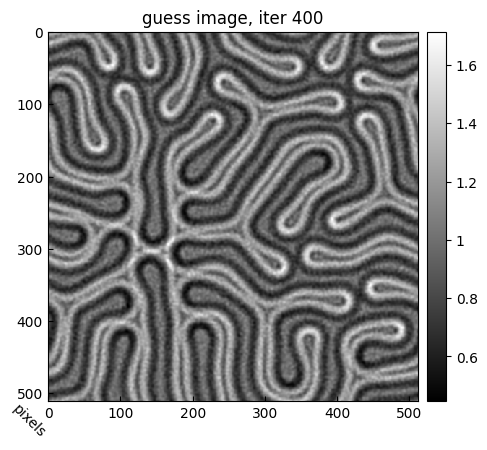

Epoch 00415: reducing learning rate of group 0 to 3.5596e-02.
Epoch 00466: reducing learning rate of group 0 to 2.6697e-02.
Epoch 00517: reducing learning rate of group 0 to 2.0023e-02.
Epoch 00568: reducing learning rate of group 0 to 1.5017e-02.
600/1000, 1.28 s : loss 1.969e-02, lr 1.50e-02


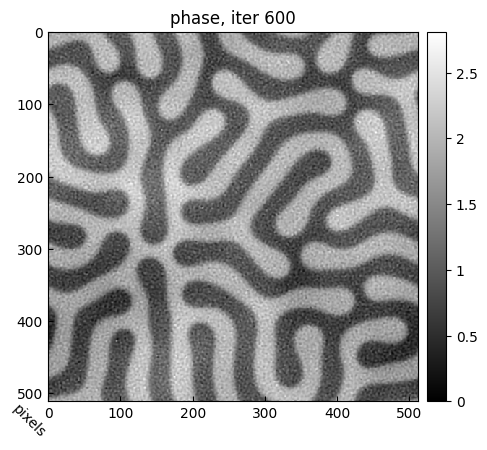

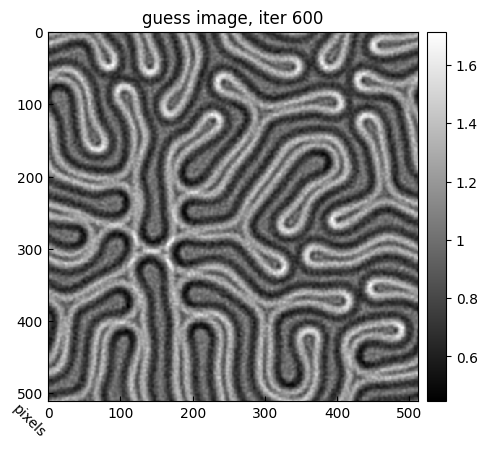

Epoch 00619: reducing learning rate of group 0 to 1.1263e-02.
Epoch 00670: reducing learning rate of group 0 to 1.0000e-02.
800/1000, 1.21 s : loss 1.969e-02, lr 1.00e-02


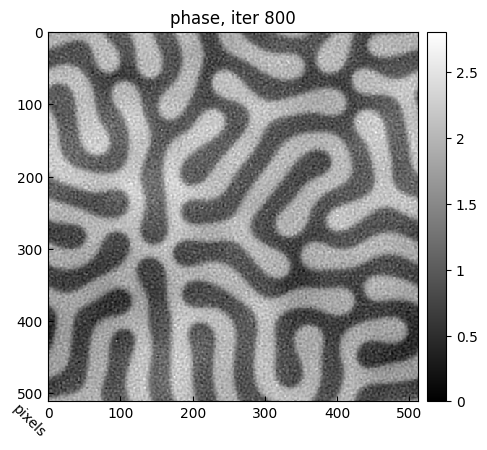

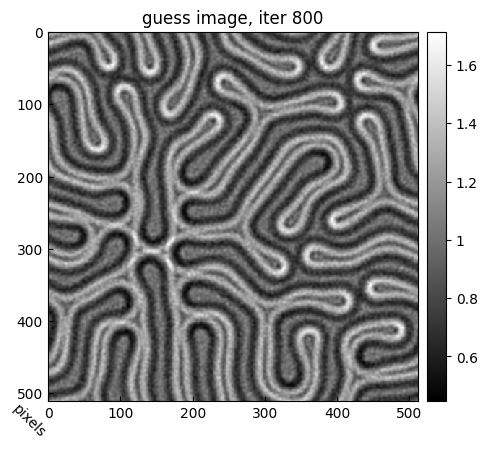

1000/1000, 1.29 s : loss 1.969e-02, lr 1.00e-02


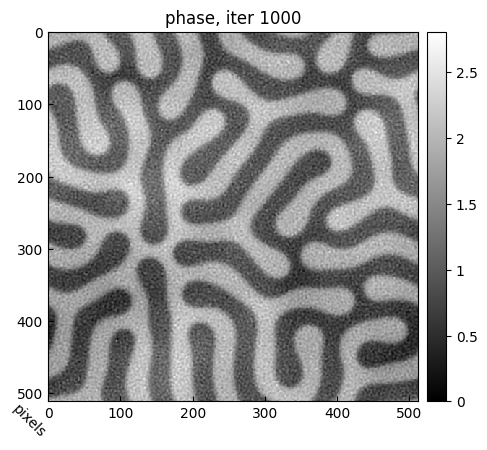

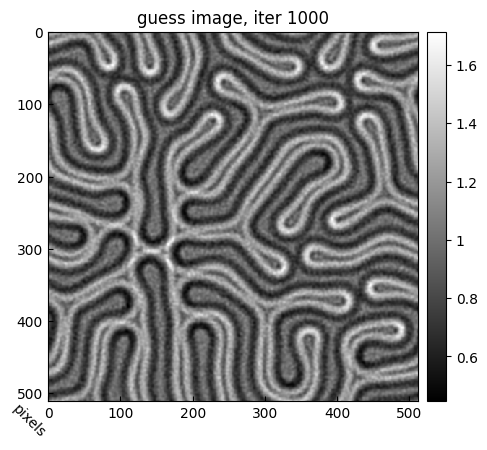

total time (h:m:s) = 0:00:09


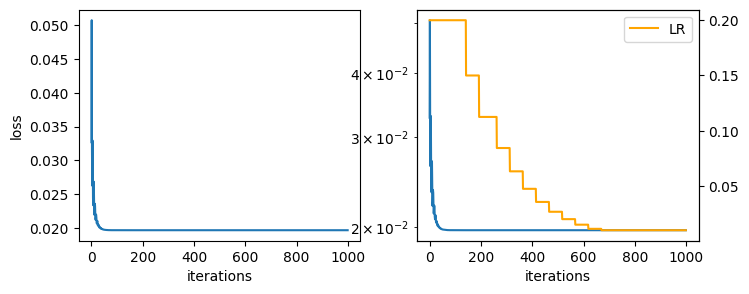

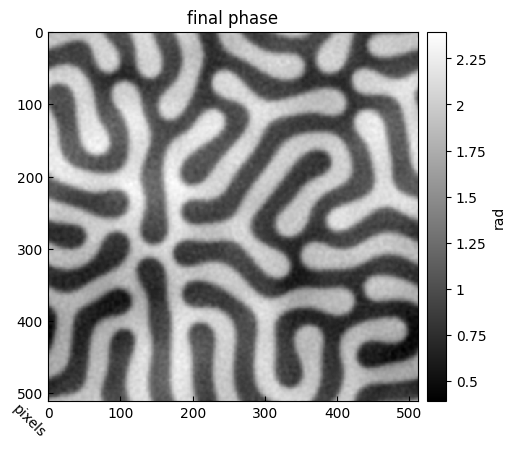


Guess phi accuracy 95.446% best accuracy: 95.446%
Guess phi SS 80.705 best phi SS: 80.704
Guess B accuracy (Bx, By, Bmag) (93.566, 93.930, 95.312)%  best accuracy: (93.566, 93.930, 95.312)%
Guess B SS (Bx, By, Bmag) (66.375, 68.237, 58.313)  best B SS: (66.375, 68.237, 58.313)



In [13]:
pdict['DIP'] = False # Use DIP
pdict['solve_amp'] = False
pdict['notes'] = ""

pdict['show'] = True

pdict['maxiter'] = 1_000
pdict['pre-train_dip'] = 100
pdict['scheduler'] = "plateau" # none, cyclic, plateau, exp
pdict['plateau_patience'] = 50

optLR = [0.2, 0.02] # (phase LR, amp LR) if not using DIP
dipLR = [2e-4, 2e-4] # LR for DIP, (phase, amp)
tvLR = [0.005, 0] # (phase TV weight, amp TV weight) (1,0) for small, only if not using DIP
sigma = 2 # gaussian smoothing output phase
pdict['DIP_noise_frac'] = 0 if pdict['solve_amp'] else 1/30
pdict["start_mode"] = "random" if pdict['solve_amp'] else "SITIE" # random, uniform, true_phase, SITIE


plt.close('all')

### define the guess or input phase/amps
if pdict["start_mode"] == "random":
    inp_phase = np.random.rand(*inp_ims[0].shape)*2-1
elif pdict["start_mode"] == "uniform":
    inp_phase = np.zeros(inp_ims[0].shape)
elif pdict["start_mode"] == "true_phase":
    inp_phase = np.copy(true_phase)
elif pdict["start_mode"] == "SITIE":
    if pdict['solve_amp']:
        print("\n============\nStarting with SITIE for solve amp, not recommended\n===========\n")
    inp_phase = SITIE(inp_ims[0].cpu().detach().numpy(),
                        dfs[0], pdict['del_px'], v=0)['phase_b']
    show_im(inp_phase, "input phase from SITIE")

guess_phase = torch.tensor(inp_phase, dtype=torch.float32, device=device,
                           requires_grad=True)
guess_amp = torch.tensor(true_amp, device=device, dtype=torch.float32, requires_grad=False)

if pdict['DIP']:
    dipP = DIP_NN().to(device)

    dipA = None
    optimizer = torch.optim.Adam([
        {'params': dipP.parameters(), 'lr':dipLR[0]},
        ])
    tvLR = [0, 0] # not strictly necessary as if pdict['DIP'] then TV loss won't be calc
    LRs = dipLR # for scheduler

else:
    dipP = None
    dipA = None
    optimizer = torch.optim.Adam([
        {'params': guess_phase, 'lr':optLR[0]}
        ])
    LRs = optLR

pdict["LRs"] = [optLR, tvLR, dipLR]
guess_amp, guess_phase, best_amp, best_phase, losses = training_loop(inp_ims,
                                                                     guess_amp,
                                                                     guess_phase,
                                                                     TFs,
                                                                     pdict,
                                                                     dipA,
                                                                     dipP,
                                                                     print_every = 200)
losses=np.array(losses)
fig, ax = plt.subplots(ncols=2, figsize = (8,3))
ax[0].plot(losses[:,0])
ax[0].set_xlabel("iterations")
ax[0].set_ylabel("loss")
ax[1].semilogy(losses[:,0], label='losses')
ax[1].set_xlabel("iterations")
ax2 = ax[1].twinx()
ax2.plot(losses[:,1],color='orange', label='LR')
plt.legend()
minloss_iter = np.argmin(losses[:,0])
fphase = guess_phase.cpu().detach().numpy()
bphase = best_phase.cpu().detach().numpy()
fphase = ndi.gaussian_filter(fphase, sigma, mode='wrap')
bphase = ndi.gaussian_filter(bphase, sigma, mode='wrap')
gamp = guess_amp.cpu().detach().numpy()
bamp = best_amp.cpu().detach().numpy()
gamp = ndi.gaussian_filter(gamp, sigma, mode='wrap')
bamp = ndi.gaussian_filter(bamp, sigma, mode='wrap')
guess_By, guess_Bx = induction_from_phase(fphase, pdict['del_px'])
best_By, best_Bx = induction_from_phase(bphase, pdict['del_px'])

show_im(fphase, "final phase", cbar_title="rad")
a = true_phase.shape[0]//16
pdict['acc_crop'] = a
get_all_accs(fphase[a:-a,a:-a], bphase[a:-a,a:-a], true_phase[a:-a,a:-a], pdict)

print(f"\nGuess phi accuracy {pdict['guess_phi_acc']*100:.3f}% best accuracy: {pdict['best_phi_acc']*100:.3f}%")
print(f"Guess phi SS {pdict['guess_phi_SS']*100:.3f} best phi SS: {pdict['best_phi_SS']*100:.3f}")

print(f"Guess B accuracy (Bx, By, Bmag) ({pdict['guess_Bx_acc']*100:.3f}, {pdict['guess_By_acc']*100:.3f}, {pdict['guess_Bmag_acc']*100:.3f})%  best accuracy: ({pdict['best_Bx_acc']*100:.3f}, {pdict['best_By_acc']*100:.3f}, {pdict['best_Bmag_acc']*100:.3f})%")
print(f"Guess B SS (Bx, By, Bmag) ({pdict['guess_Bx_SS']*100:.3f}, {pdict['guess_By_SS']*100:.3f}, {pdict['guess_Bmag_SS']*100:.3f})  best B SS: ({pdict['best_Bx_SS']*100:.3f}, {pdict['best_By_SS']*100:.3f}, {pdict['best_Bmag_SS']*100:.3f})\n")
